## Task 1
This notebook focuses on getting the given dataset ready for developing machine learning models through pre-processing and transformation. The top 10 most important features are identified using pearson correlation and then used to build an SVM classifier, which was then holistically evaluated.

<p style="font-style: italic;">Note - In each step, there were multiple methods of implementation that were tried hence, the addiditonal code for each section. For example: For normalisation, three different types were used for experimentation</p>



Write a Python program to pre-process and transform the dataset into a format suitable for developing machine learning models. Use pearson correlation method to identify ten most important features. Use these features to build a SVM classifier and evaluate your model’s performance.

<span style="font-weight:bold;">Save your response (program and markdown) as task1.ipynb.</span>

In [2]:
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt 
from functions.pre_processing import *
from functions.transformations import *
from functions.feature_selection import *
from functions.analysis import *
from functions.classifiers import *
from functions.model import *
from functions.evaluation import *
from sklearn.metrics import accuracy_score

In [3]:
x_train, x_test, y_train, y_test = fetch_datasets()
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(16200, 512)
(5400, 512)
(16200,)
(5400,)


-----------------------------------------------------------------
## Pre-Processing and Transformation

The pre-processing stage consisted of trying to find outliers in the train and test sets. Outliers were defined as features with no unique values or values that weren't numeric/missing. Thorugh analysis, it was found that no outliers exist hence why techniques like `Imputation` was not used as it is only relevant for handling missing values.

Visualisations were added to see the split of values and identify how data was spread out and whether there was a skew towards specific value. If there was a skew, the hypothesis was that this could be affecting the model's performance towards a specific class.

Conclusion - It can be seen that there are no outliers amongst the features and classes


No features with 1 unique value
Missing Values in x_train -> 0, Missing Values in x_test -> 0
Missing Values in y_train -> 0, Missing Values in y_test -> 0


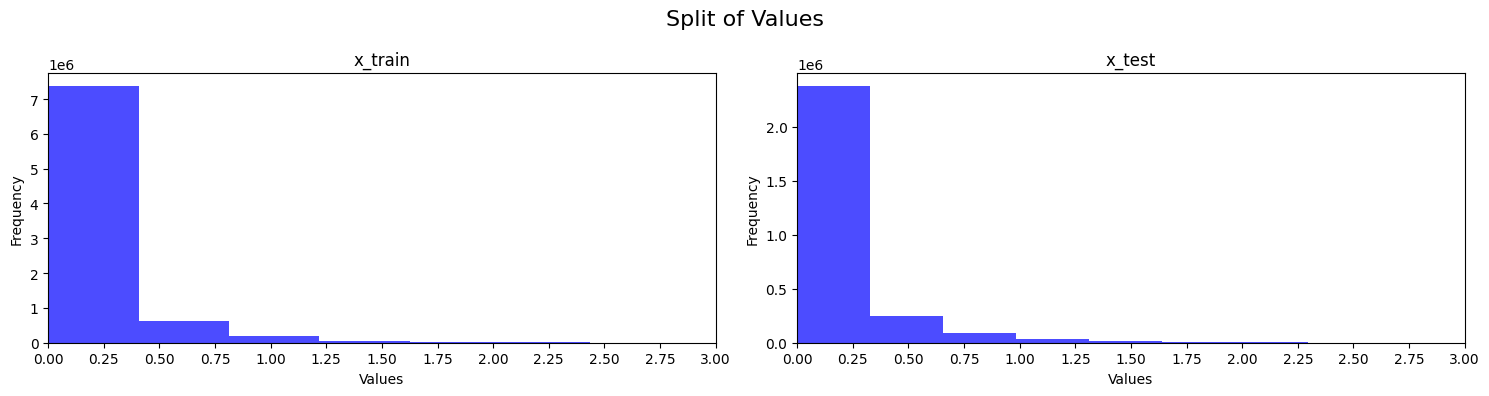

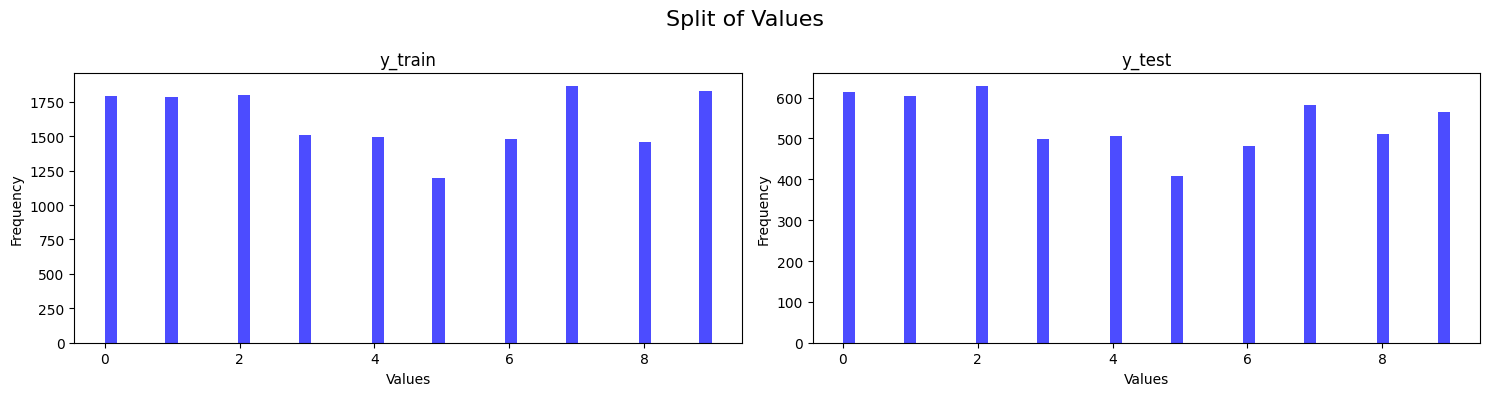

In [4]:
'''
Try different techniques of pre processing and transformation and see the difference in results?
'''

# Checking for unique values of feature, there were 0 features in the train set with more than 1 unique value
# In the test set, there was one feature with 2 unique values, but I chose to keep this as if this feature has strong correlation with the target variablee, it could still be useful
num_features = x_test.shape[1]
unique_value_counts = [len(np.unique(x_test[:, i])) for i in range(num_features)]
filtered_features = [(i+1, count) for i, count in enumerate(unique_value_counts) if count == 1]

if len(filtered_features) == 0:
    print("No features with 1 unique value")
else:
    for feature, count in filtered_features:
        print("Features with less than 100 unique values:")
        print(f"Feature {feature}: {count} unique values")

# Checking for missing values
print(f"{find_missing_values(x_train, "x_train")}, {find_missing_values(x_test, "x_test")}")
print(f"{find_missing_values(y_train, "y_train")}, {find_missing_values(y_test, "y_test")}")

plot_feature_split_of_values([x_train, x_test], ["x_train", "x_test"])
plot_class_split_of_values([y_train, y_test], ["y_train", "y_test"])

# ---- Tried removing scientific notation from numbers to see if that would present difference split of outputs (for features only) - this made no difference ----
# for i in range(len(x_train)):
#     for x in range(len(x_train[i])):
#         x_train[i][x] = '{:.8f}'.format(x_train[i][x])

# for i in range(len(x_test)):
#     for x in range(len(x_test[i])):
#         x_test[i][x] = '{:.8f}'.format(x_train[i][x])

-----------------------------------------------------------------
## Normalisation

As seen from the split of data above, the feature train and test datasets had a range between 0 and 2.5. To ensure features were on a similar scale, normalisation was used. Multiple types of scaling was experimented with - (i) Min Max, (ii) Standardisation, and (iii) Robust Scaler. The hypotheses tested with each is mentioned below.

1. <b>Min Max <span style="color: darkgreen;">[Best Performance]</span></b> - Scales the data to a fixed range (in this case, [-1, 1]) [1]. As no outliers were detected, this was used to linearly scale the features down to a defined range and presented the best testing accuracy.<span style="font-style: italic;">

2. <b>StandardScaler</b> - Scales the data based on the mean and standard deviation, so that each have values of 0 and 1 respectively. MinMaxScaler was used over StandardScaler as (i) the testing accuracy was better and (ii) the upper and lower bound of values were known.

3. <b>RobustScaler</b> - RobustScaler scales the data based on statistics and percentiles, protecting it against outliers unlike the above two methods [3]. Since there were no outliers in this dataset, it was not needed.

<span style="font-style: italic;">PS: Would not use MinMax or StandardScaler if outliers were detected as it is very sensitive to the presence of outliers</span>

datasets/task1/x_train has the new model!
datasets/task1/x_test has the new model!
datasets/task1/y_train has the new model!
datasets/task1/y_test has the new model!


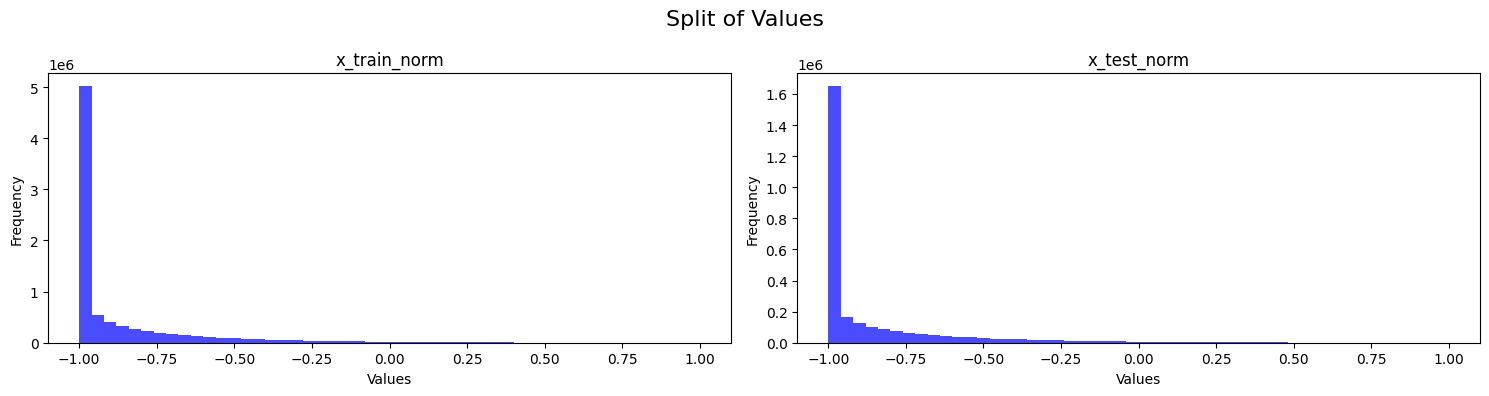

In [5]:
# ------- TRANSFORMATION ---------
x_train_norm, x_test_norm = normalise_min_max(x_train, x_test)
# x_train_norm, x_test_norm = normalise_std_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.5945061728395061 | Testing Accuracy: 0.5559259259259259
# x_train_norm, x_test_norm = normalise_robust_scaler(x_train, x_test) # Best configuration - Training Accuracy: 0.5701234567901234 | Testing Accuracy: 0.5364814814814814

save_model(x_train_norm, "datasets/task1/x_train")
save_model(x_test_norm, "datasets/task1/x_test")
save_model(y_train, "datasets/task1/y_train")
save_model(y_test, "datasets/task1/y_test")

# Split of values after normalisation
plot_class_split_of_values([x_train_norm, x_test_norm], ["x_train_norm", "x_test_norm"])

## Feature Selection

This section goes over the feature selection processs of getting the top 10 features using Pearson correlation. The features of this set are all numerical as these are the extracted features from the input images. Due to this, it was assumed that the features did not consist of any order (Ordinal).

The aim of this section was to (i) Find and eliminate the features that are redundant as otherwise the top features could consist of redundant features, (ii) Use Pearson's correlation to identify the top 10 features, and (iii) Compare the model's performance with other feature selection methods.

<b>In this case, the feature selection presents a numerical input and output</b>

---------

<b>Removing redundant features</b>

To remove features of little importance, variance threshold was used. Variance threshold looks for the features with low variance below a threshold and removes it, due to its potential redundancy. This was implemented to eradicate the prospect of the top 10 features having redundant/overlappng features.

The threshold was calculated by taking the average of all features due to the high number and variability of outputs.

In [6]:
# ------- REMOVING REDUNDANT FEATURES -------
x_train_selected, x_test_selected = calculate_variance_threshold(x_train_norm, x_test_norm)

(16200, 242)
(5400, 242)


To ensure the features had a linear relationship with the target variable, both `r_regression` and `f_regression` were used. Whilst `r_regression` follows the task requirements and retrieves the Pearson correlation coefficient to calculate the top 10 features, it is heavily used to quantify the strength of linear relationships between individual features and target variable. 

`f_regression` was used to evaluate the overall significance of each feature in explaining the variance in the target variable. Due to the high number of features, `f_regression` can be more efficient than `r_regression` because it considers the joint effect of all features on the target variable.

<b>Conclusion - after evaluating both methods, the top 10 features were the same. This concluded that the features exhibited linear relationships with the target variable, with both functions capturing the linear association similarly.</b>

The top 10 features before variance threshold are -> [178 479 136 369 254 440  38 485 116  64]
The top 10 features for f_reg before variance threshold are -> [178 479 136 369 254 440  38 485 116  64]
The top 10 features are -> [224 171 112 205  15  31 196 145 237 225]
The top 10 features f_reg are -> [224 171 112 205  15  31 196 145 237 225]


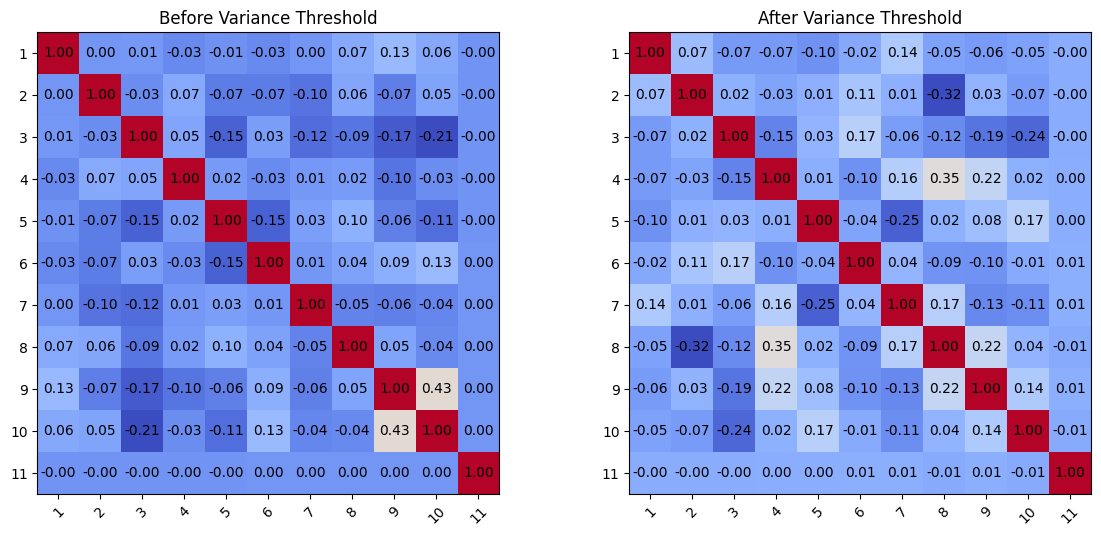

In [7]:
# ------- FEATURE SELECTION ---------
feature_correlation_pre = pearson_correlation(x_train_norm, y_train)
print(f"The top 10 features before variance threshold are -> {feature_correlation_pre[:10]}")
feature_correlation_f_reg_pre = f_regression_scores(x_train_norm, y_train)
print(f"The top 10 features for f_reg before variance threshold are -> {feature_correlation_f_reg_pre[:10]}")

feature_correlation = pearson_correlation(x_train_selected, y_train)
print(f"The top 10 features are -> {feature_correlation[:10]}")
feature_correlation_f_reg = f_regression_scores(x_train_selected, y_train)
print(f"The top 10 features f_reg are -> {feature_correlation_f_reg[:10]}")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# pre variance threshold
top_features_indices = feature_correlation_pre[:10]
selected_features = x_train_norm[:, top_features_indices]
correlation_matrix_pre = np.corrcoef(selected_features.T, y_train)
plot_correlation_heatmap(axes[0], correlation_matrix_pre, 'Before Variance Threshold')

# Post variance threshold
top_features_indices = feature_correlation[:10]
selected_features = x_train_selected[:, top_features_indices]
correlation_matrix = np.corrcoef(selected_features.T, y_train)
plot_correlation_heatmap(axes[1], correlation_matrix, 'After Variance Threshold')

Correlation heatmaps were used to evaluate the significance of the relationships between features. The hypotheses was that after performing variance threshold and removing the redundant features, (i) Thesre would be weaker correlation between other features (lighter colors on the heatmap), and the (ii) Training and testing accuracy would improve. As seen above, the heatmap shows a clear difference in correlation representation between features and as a result, the train and test accuracy has also improved from `0.588` and `0.541` to `0.610` and `0.579` respectively.

-----------------------------------------------------------------
## Training and Validation

In this section, the model is trained with the dataset's top 10 features which was calculated using Pearson Correlation. The results were then validated using the following methods mentioned below:

1. Holdout Validation - Training the model using the testing set and evaluating it using the validation set

2. Cross Validation - Splits the model into k folds, trains and validated on each and presents a more reliable model performance

3. Stratified K-fold Validation - Similar to Cross Validation, but was used as it ensures the same percentage of samples for each class are preserved [4].

<b>Support Vector Classification (SVC) is used over Support Vector Regression (SVR) in this coursework as the dataset is used for image classification</b>

In [8]:
svc_results = svc_classifier(x_train_selected[:, top_features_indices], x_test_selected[:, top_features_indices], y_train, y_test)
save_model(svc_results, "models/task1/svc_results") # The model is saved as it may be needed elsewhere

------ Holdout Validation ------
Training Accuracy: 0.610246913580247
Testing Accuracy: 0.567037037037037
------ Cross Validation ------
Mean Accuracy: 0.5775308641975309
------ K fold Validation ------
Mean Accuracy: 0.5799537037037037
Std Deviation: 0.013796840034027877
------ Stratified K fold Validation ------
Mean Accuracy: 0.577037037037037
Std Deviation: 0.007009571156033375
models/task1/svc_results has the new model!


-----------------------------------------------------------------
## Hyperparameter Optimisation
Mention tried different params to increase margin between train test accuracy, increasing accuracy but risking overfitting
The parameters that were manually tested were (what did you want to test?):

1. <b>c -</b> This is the regularisation parameter, representing the penalty for misclassification of outputs.

2. <b>kernel -</b> This is xyz

3. <b>gamma -</b> This is xyz

The best configuration was with the parameters -> 
Train accuracy -> <b style="color: orange;">[add here]</b>, Test accuracy -> <b style="color: orange;">[add here]</b>

<b>Note - Running the code below will take approximately 2 hours to finish execution</b>

In [12]:
c_values = [1, 10, 50, 100]
kernels_values = ["linear", "rbf", "poly", "sigmoid"]
gamma_values = ["scale", "auto", 0.01, 0.1]
selected_c = 0 
selected_kernel = ''
selected_gamma = '' 
best_training = 0
best_test = 0

# Nested CV use here 
for values in range(len(kernels_values)):
     for c_vals in range(len(c_values)):
          for g_values in range(len(gamma_values)):
               svc_clf = SVC(C=c_values[c_vals], gamma=gamma_values[g_values], kernel=kernels_values[values])
               svc_clf.fit(x_train_selected[:, top_features_indices], y_train)
               current_train = svc_clf.score(x_train_selected[:, top_features_indices], y_train) 
               current_test = svc_clf.score(x_test_selected[:, top_features_indices], y_test)
               cv_score = cross_val_score(svc_clf, x_train_selected[:, top_features_indices], y_train, cv=10)
               cv_mean_accuracy = np.mean(cv_score)

               if (current_train > best_training) and (current_test > best_test):
                    best_training = current_train
                    best_test = current_test
                    selected_c = c_values[c_vals]
                    selected_kernel = kernels_values[values]
                    selected_gamma = gamma_values[g_values]

               print(f"------- With C={c_values[c_vals]}, gamma={gamma_values[g_values]}, kernel={kernels_values[values]}")
               print(f"Training Accuracy - {current_train} | Testing Accuracy - {current_test}, Cross Validation - {cv_mean_accuracy}")

print(f"The best configuration is C={selected_c}, gamma={selected_gamma}, kernel={selected_kernel}")
print(f"Training Accuracy - {best_training} | Testing Accuracy - {best_test}, Cross Validation - {cv_mean_accuracy}")

------- With C=1, gamma=scale, kernel=linear
Training Accuracy - 0.48987654320987656 | Testing Accuracy - 0.47944444444444445, Cross Validation - 0.48685185185185187
------- With C=1, gamma=auto, kernel=linear
Training Accuracy - 0.48987654320987656 | Testing Accuracy - 0.47944444444444445, Cross Validation - 0.48685185185185187
------- With C=1, gamma=0.01, kernel=linear
Training Accuracy - 0.48987654320987656 | Testing Accuracy - 0.47944444444444445, Cross Validation - 0.48685185185185187
------- With C=1, gamma=0.1, kernel=linear
Training Accuracy - 0.48987654320987656 | Testing Accuracy - 0.47944444444444445, Cross Validation - 0.48685185185185187
------- With C=10, gamma=scale, kernel=linear
Training Accuracy - 0.4918518518518519 | Testing Accuracy - 0.47962962962962963, Cross Validation - 0.4890123456790123
------- With C=10, gamma=auto, kernel=linear
Training Accuracy - 0.4918518518518519 | Testing Accuracy - 0.47962962962962963, Cross Validation - 0.4890123456790123
------- Wit

-----------------------------------------------------------------
## Evaluation
This section goes over the performance of the model, how and it what areas it could be improved, and metrics used to track this

#### Classification Report
The classification report is used to evaluate the performance of a classification model, specifically needed to see the split of the classes and the accuracy of predictions. The split of classes is valuable as there is a slight imbalance in the amount of samples per class.
The goal of seeing this is confirming the hypothesis that the accuracy of the model is low because of either (i) the imbalance in samples per classes and (ii) the number of features being used for training not being enough, with the report focusing on the former.

In [9]:
fetch_classification_report(svc_results, x_test_selected[:, top_features_indices], y_test)

----- Classification Report -----
              precision    recall  f1-score   support

         0.0       0.62      0.69      0.66       613
         1.0       0.69      0.81      0.75       605
         2.0       0.45      0.46      0.45       628
         3.0       0.45      0.35      0.40       499
         4.0       0.46      0.50      0.48       507
         5.0       0.47      0.36      0.41       409
         6.0       0.41      0.30      0.35       481
         7.0       0.64      0.76      0.69       583
         8.0       0.48      0.48      0.48       511
         9.0       0.81      0.79      0.80       564

    accuracy                           0.57      5400
   macro avg       0.55      0.55      0.55      5400
weighted avg       0.56      0.57      0.56      5400



Observations
- classes with low samples have the worst precision (TP success prediction) and recall (rate of predicting all TP) -> <b>Lowest 6 f1-score, 5 were the lowest amount of samples (except for class 2.0)</b>
- worst performance is within classes 2.0 - 6.0, with recall averaging 0.39 -> <b>indicating that model projects majority of the true occurences as false</b>

Conclusion - The imbalance in the dataset does seem to affect the accuracy of classes, with accuracy varying throughout

-----

Continuing from the the last section, the second assumption had to be validated. To do so, the model was trained with more features (taken 50 as a random amount). Immediately, what was visible is that the train and test accuracy reached `0.922` and `0.866` respectively.

<b>This concludes thathe model's accuracy being low is directly correlated to the number of features it is trained on</b>

In [ ]:
svc_classifier(x_train_selected[:, feature_correlation[:50]], x_test_selected[:, feature_correlation[:50]], y_train, y_test)

------ Holdout Validation ------
Training Accuracy: 0.9228395061728395
Testing Accuracy: 0.8557407407407407
------ Cross Validation ------
Mean Accuracy: 0.8617901234567901
------ K fold Validation ------
Mean Accuracy: 0.8665277777777778
Std Deviation: 0.00994357796763087
------ Stratified K fold Validation ------
Mean Accuracy: 0.8660185185185185
Std Deviation: 0.0068737138714694175


SVC(C=1, probability=True)

#### Confusion Matrix
A confusion matrix was needed to evaluate the true against the predicted results for each class. In doing so, it will help retrieve and evaluate the `True Positive`, `True Negative`, `False Positive`, and `False Negative` for each class.

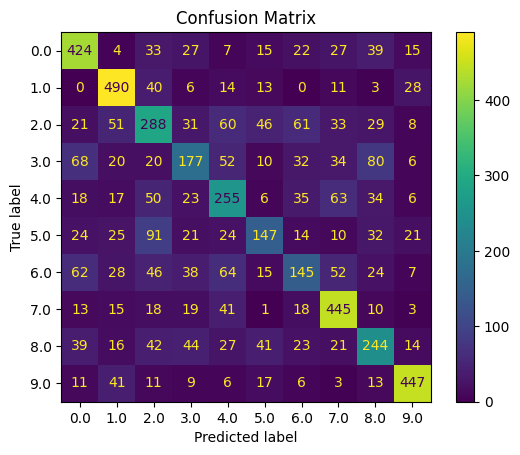

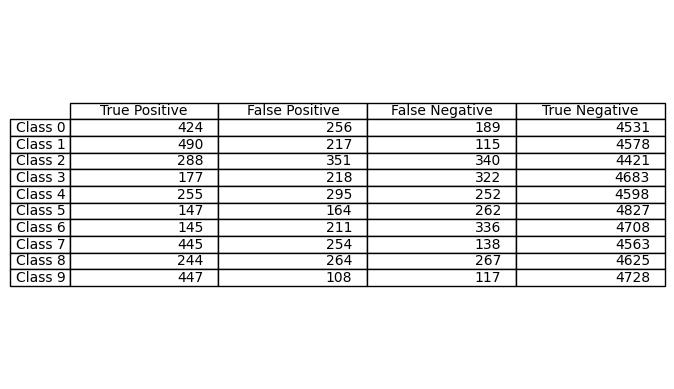

In [10]:
plot_confusion_matrix(svc_results, x_test_selected[:, top_features_indices], y_test)

## Spectral Bands and Classes
<img title="a title" alt="Alt text" src="Images/spectral_bands.png" width="250" height="200"> <img title="a title" alt="Alt text" src="Images/sample_image_patches.png" width="350" height="200">

The three bands B01, B09 and B10 are intended to be used for the correction of atmospheric effects(e.g., aerosols, cirrus or water vapor). The remaining bands are primarily intended to identify and monitor land use and land cover classes.

#### Precision-Recall, ROC, and DET Curve

1. <b>Precision-Recall Curve -</b> Measures the trade-off between precision (`TP/(TP+FP)`) and recall (`TP/(TP+FN)`) for each class.

2. <b>Receiver Operating Curve -</b> Measures the comparison between the True Positive and False Positive for each class

3. <b>Detection Error Tradeoff Curve -</b> Measures the comparison between the False Positive and False Negative for each class

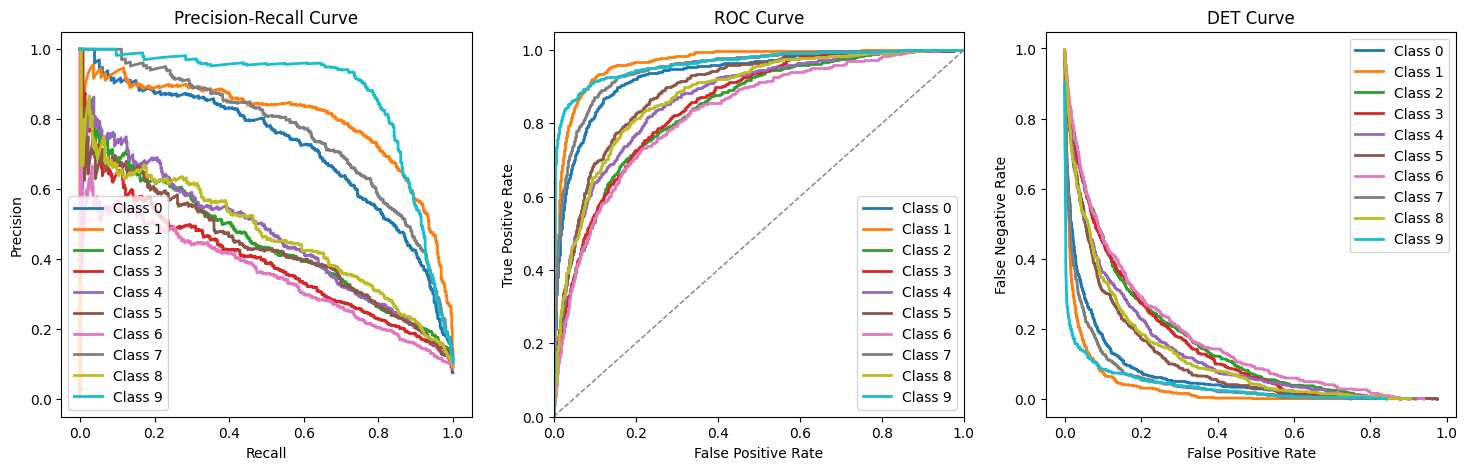

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
y_pred = svc_results.predict_proba(x_test_selected[:, top_features_indices])
plot_precision_recall_curve(y_test, y_pred, axes[0])
plot_roc_curve(y_test, y_pred, axes[1])
plot_det_curve(y_test, y_pred, axes[2])

#### Classification Metrics (?) -> Do I need? Maybe check classification papers online?

<span style="font-weight: bold;">Markdown Question:</span> The difficulty in using pearson correlation method for feature selection is determining the appropriate number of features to select. The method described in the module to <span style="font-weight: bold; color: green">automatically choose</span> the appropriate number of features will be computationally very expensive when the number of features is high. <span style="font-weight: bold; color: aqua">Describe an alternative method to reduce the computational complexity of the method discussed in class for datasets with large number of features.</span>  <span style="font-weight: bold;">(150 words)</span>

<span style="font-weight: bold;">Answer:</span> A combination of a heuristic search algorithm like Sequential Forward Search (SFS) and a ranking algorithm can be used to reduce computational complexity. SFS is a wrapper-based algorithm that selects the best features starting from 0. It chooses the best feature to add in each step based on the cross-validation score of the estimator and keeps incrementally adding features to find the right amount. To alleviate the computation risk with SFS when using a high number of features, pre-ranking should be performed so that SFS is performed on the most relevant and non-redundant feature set. This would reduce the number of steps and computational complexity to find the appropriate features.

Alongside the approach, best practices such as early stopping and parallelisation should also be implemented to ensure computationally intensive tasks are performed only when necessary and without using the load of a single machine.

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

## References

[1] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

[2] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[3] https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html

[4] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html